In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [2]:
include("../env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [3]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=1000"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [4]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-02-06T10:52:34"
fromTime = "2020-02-06T10:52:39"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,11.94,11.97,12.0,11.92,7.05952e6,2017-06-29T04:00:00
2,11.94,11.94,11.98,11.93,5.13607e6,2017-06-30T04:00:00
3,11.78,11.74,11.82,11.73,8.0437e6,2017-07-03T04:00:00
4,11.72,11.785,11.8,11.72,6.56592e6,2017-07-05T04:00:00
5,11.79,11.78,11.795,11.75,7.08917e6,2017-07-06T04:00:00
6,11.71,11.66,11.71,11.6141,1.03676e7,2017-07-07T04:00:00
7,11.63,11.68,11.69,11.61,5.52857e6,2017-07-10T04:00:00
8,11.65,11.7,11.71,11.62,6.51704e6,2017-07-11T04:00:00
9,11.75,11.73,11.77,11.72,4.37305e6,2017-07-12T04:00:00


In [5]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

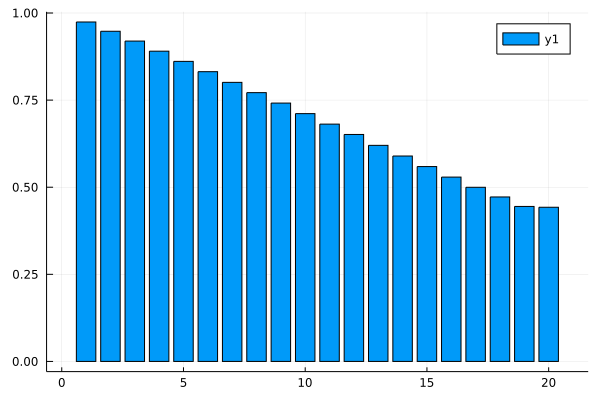

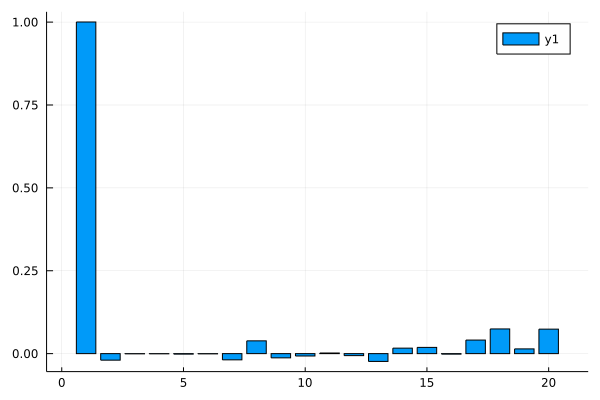

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.00136198

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9289

Details:
    sample size in regression:          998
    number of lags:                     1
    ADF statistic:                      1.0996
    Critical values at 1%, 5%, and 10%: [-2.56798 -1.94127 -1.61656]


In [7]:
testStationary(df2[!,:Close])

In [8]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [9]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
prices = merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])


1000×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2017-06-29T04:00:00 to 2021-06-18T04:00:00
│                     │ Close1 │ Close2  │
├─────────────────────┼────────┼─────────┤
│ 2017-06-29T04:00:00 │ 118.32 │ 11.97   │
│ 2017-06-30T04:00:00 │ 118.03 │ 11.94   │
│ 2017-07-03T04:00:00 │ 116.04 │ 11.74   │
│ 2017-07-05T04:00:00 │ 116.54 │ 11.785  │
│ 2017-07-06T04:00:00 │ 116.46 │ 11.78   │
│ 2017-07-07T04:00:00 │ 115.27 │ 11.66   │
│ 2017-07-10T04:00:00 │ 115.46 │ 11.68   │
│ 2017-07-11T04:00:00 │ 115.64 │ 11.7    │
│ 2017-07-12T04:00:00 │ 116.01 │ 11.73   │
│ 2017-07-13T04:00:00 │ 115.82 │ 11.71   │
│ 2017-07-14T04:00:00 │ 116.78 │ 11.81   │
│ 2017-07-17T04:00:00 │ 117.29 │ 11.86   │
   ⋮
│ 2021-06-04T04:00:00 │ 177.17 │ 36.04   │
│ 2021-06-07T04:00:00 │ 177.88 │ 36.185  │
│ 2021-06-08T04:00:00 │ 177.3  │ 36.07   │
│ 2021-06-09T04:00:00 │ 176.97 │ 36.0    │
│ 2021-06-10T04:00:00 │ 177.73 │ 36.16   │
│ 2021-06-11T04:00:00 │ 175.7  │ 35.74   │
│ 2021-06-14T04:00:00 │ 174.73 │ 35.

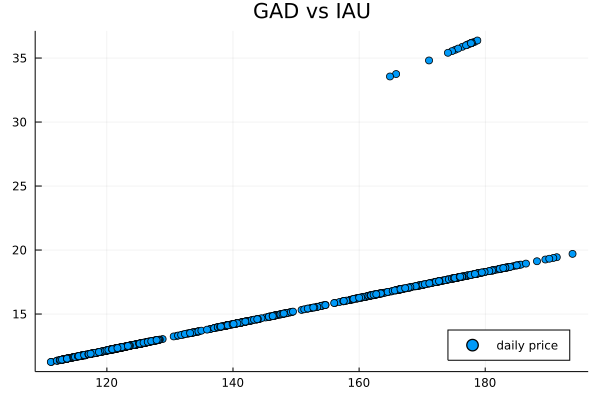

In [10]:
prices_df = DataFrame(prices)
x = prices_df[!,:Close1]
y = prices_df[!,:Close2]
plot(x, y, seriestype = :scatter, title = "GAD vs IAU", label = "daily price",legend=:bottomright)

In [11]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = -0.010218033f0
size(current) = (1, 4)


0.008288691f0

mean(df[!, :Diff]) = -7.099472f-5
std(df[!, :Diff]) = 0.00035369786f0


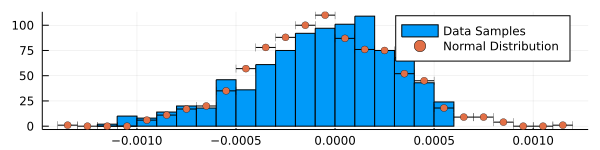

In [12]:
using Random, Distributions
using StatsBase
df = DataFrame(data)

lower = quantile(df[:,:Diff], 0.01)
upper = quantile(df[:,:Diff], 0.91)
df = filter(:Diff => x -> x > lower, df)
df = filter(:Diff => x -> x < upper, df)
@show mean(df[!,:Diff])
@show std(df[!,:Diff])
histogram(df[!,:Diff], labels="Data Samples")
d=fit(Normal, df[!,:Diff])
n = length(df[:,:Diff])
plot!(rand(d, n), seriestype=:scatterhist, linestyle=:solid, size=(600,150),labels="Normal Distribution")


In [13]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -6.946984817239867e-5
std(rand(d, 10000)) = 0.00035271310487533264


0.00035271310487533264

In [14]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -6.779180940466179e-5
std(rand(d, 10000)) = 0.00035738239187600853


0.00035738239187600853

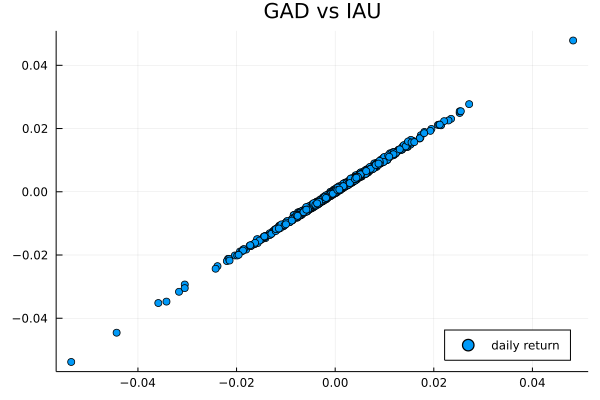

In [15]:
x = df[!,:Close1]
y = df[!,:Close2]
plot(x, y, seriestype = :scatter, title = "GAD vs IAU", label = "daily return",legend=:bottomright)

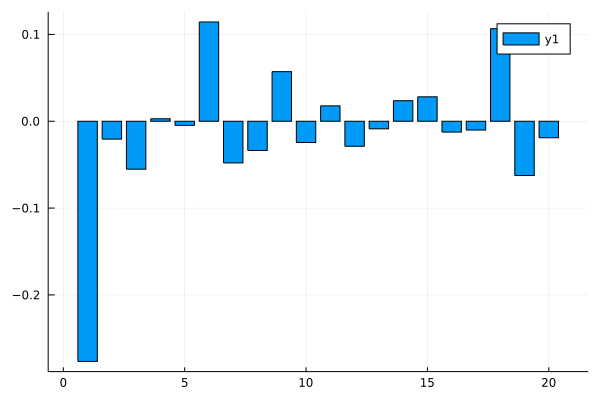

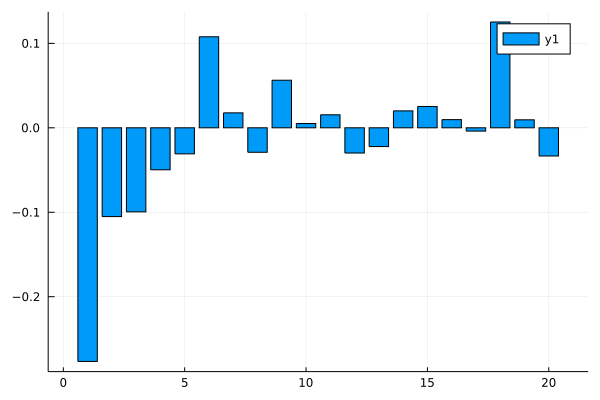

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.26952

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          897
    number of lags:                     1
    ADF statistic:                      -24.2522
    Critical values at 1%, 5%, and 10%: [-2.56823 -1.9413 -1.61653]


In [16]:
testStationary(df[!,:Diff])

In [17]:

function BuyOrSell(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1,mean2 = values(mean(pct[1:lookback-1]))
    @show mean1
    @show mean2
    std1,std2 = values(std(pct[1:lookback-1]))
    @show std1
    @show std2
    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12
    p1 = values(pct[lookback,:Close1])[1]
    p2 = values(pct[lookback,:Close2])[1]
    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]
    @show p1
    @show p2
    @show dif12

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

BuyOrSell (generic function with 1 method)

In [18]:

function BBand(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1,mean2 = values(mean(pct[1:lookback-1]))
    @show mean1
    @show mean2
    std1,std2 = values(std(pct[1:lookback-1]))
    @show std1
    @show std2
    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12
    p1 = values(pct[lookback,:Close1])[1]
    p2 = values(pct[lookback,:Close2])[1]
    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]
    @show p1
    @show p2
    @show dif12

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
    elseif p1 <= mean1 - thd2*std1
        act1 = 1
    end
    if p2 >= mean2 + thd2*std2
        act2 = -1
    elseif p2 <= mean2 - thd2*std2
        act2 = 1
    end
    return (act1,act2)
end

BBand (generic function with 1 method)

In [19]:
pct

999×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2017-06-30T04:00:00 to 2021-06-18T04:00:00
│                     │ Close1  │ Close2  │
├─────────────────────┼─────────┼─────────┤
│ 2017-06-30T04:00:00 │ -0.0025 │ -0.0025 │
│ 2017-07-03T04:00:00 │ -0.0169 │ -0.0168 │
│ 2017-07-05T04:00:00 │ 0.0043  │ 0.0038  │
│ 2017-07-06T04:00:00 │ -0.0007 │ -0.0004 │
│ 2017-07-07T04:00:00 │ -0.0102 │ -0.0102 │
│ 2017-07-10T04:00:00 │ 0.0016  │ 0.0017  │
│ 2017-07-11T04:00:00 │ 0.0016  │ 0.0017  │
│ 2017-07-12T04:00:00 │ 0.0032  │ 0.0026  │
│ 2017-07-13T04:00:00 │ -0.0016 │ -0.0017 │
│ 2017-07-14T04:00:00 │ 0.0083  │ 0.0085  │
│ 2017-07-17T04:00:00 │ 0.0044  │ 0.0042  │
│ 2017-07-18T04:00:00 │ 0.0068  │ 0.0067  │
   ⋮
│ 2021-06-04T04:00:00 │ 0.011   │ 0.0111  │
│ 2021-06-07T04:00:00 │ 0.004   │ 0.004   │
│ 2021-06-08T04:00:00 │ -0.0033 │ -0.0032 │
│ 2021-06-09T04:00:00 │ -0.0019 │ -0.0019 │
│ 2021-06-10T04:00:00 │ 0.0043  │ 0.0044  │
│ 2021-06-11T04:00:00 │ -0.0114 │ -0.0116 │
│ 2021-06-14T04:0

In [20]:

function MR0(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    

    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12

    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]

    @show dif12

    act1 = 0
    act2 = 0
    thd1 = 1

    if dif12 > mean12 + thd1*std12
            act1 = -1
            act2 = 1
    elseif dif12 < mean12 - thd1*std12
            act1 = 1
            act2 = -1
    end        
    return (act1,act2)
end

MR0 (generic function with 1 method)

In [21]:
lookback,_ = size(pct)
half_lookback = Int(floor(lookback/2))
@show lookback, half_lookback
mean(values(pct[:Close1][half_lookback:lookback-1])) - mean(values(pct[:Close1][1:lookback-1]))


(lookback, half_lookback) = (999, 499)


0.000108635286f0

In [22]:

function MR0MA(pct)
    lookback,_ = size(pct)
    half_lookback = Int(floor(lookback/2))
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mm1 = mean(values(pct[:Close1][half_lookback:lookback-1])) - mean(values(pct[:Close1][1:lookback-1]))
    mm2 = mean(values(pct[:Close2][half_lookback:lookback-1])) - mean(values(pct[:Close2][1:lookback-1]))

    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12

    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]

    @show dif12

    act1 = 0
    act2 = 0
    thd1 = 0.5

    if dif12 > mean12 + thd1*std12
        if mm1 < 0
            act1 = -1
        end
        if mm2 > 0
            act2 = 1
        end
    elseif dif12 < mean12 - thd1*std12
        if mm1 > 0
            act1 = 1
        end
        if mm2 < 0
            act2 = -1
        end
    end        
    return (act1,act2)
end

MR0MA (generic function with 1 method)

In [23]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(prices[:Close1] ./ prices[:Close2], :Close1_Close2 => :Diff)
lookback = 21
timestampRows = DateTime[]
signal1 = Float32[]
signal2 = Float32[]
for (row_index,row) in enumerate(eachrow(pct))
    if row_index >= lookback
        i = row_index
        buy1,buy2 =  MR0MA(pct[i-lookback+1:i])
        @show buy1,buy2
        append!(timestampRows, [row.timestamp])
        append!(signal1, [buy1])
        append!(signal2, [buy2])
    end
    
end
resultTab = (datetime = timestampRows,
        Signal1 = signal1, Signal2 = signal2
    )
        
resultTA = TimeArray(resultTab; timestamp = :datetime, meta = "result")

std12 = 0.0003533946f0
dif12 = 0.000248463f0
(buy1, buy2) = (0, 1)
std12 = 0.00035751623f0
dif12 = 7.337547f-5
(buy1, buy2) = (0, 0)
std12 = 0.0003565631f0
dif12 = -0.00018421654f0
(buy1, buy2) = (1, 0)
std12 = 0.0003426052f0
dif12 = 0.0005909834f0
(buy1, buy2) = (0, 1)
std12 = 0.00036227203f0
dif12 = -0.00041240966f0
(buy1, buy2) = (1, 0)
std12 = 0.00037552472f0
dif12 = -0.00034345646f0
(buy1, buy2) = (0, -1)
std12 = 0.00038359858f0
dif12 = 0.0006146836f0
(buy1, buy2) = (-1, 0)
std12 = 0.00040542585f0
dif12 = 0.0002940325f0
(buy1, buy2) = (-1, 0)
std12 = 0.00038561205f0
dif12 = -0.0004897411f0
(buy1, buy2) = (0, -1)
std12 = 0.00040178522f0
dif12 = 5.0052535f-5
(buy1, buy2) = (0, 0)
std12 = 0.00039782186f0
dif12 = 0.00040323846f0
(buy1, buy2) = (-1, 0)
std12 = 0.00040680353f0
dif12 = -0.0010542241f0
(buy1, buy2) = (0, -1)
std12 = 0.0004719802f0
dif12 = -7.8773126f-5
(buy1, buy2) = (0, 0)
std12 = 0.00046674517f0
dif12 = 0.00055046333f0
(buy1, buy2) = (-1, 0)
std12 = 0.0004840663f0
dif12

dif12 = 0.00045130937f0
(buy1, buy2) = (0, 1)
std12 = 0.0005460415f0
dif12 = -0.000255052f0
(buy1, buy2) = (0, 0)
std12 = 0.0005215544f0
dif12 = 0.00021536706f0
(buy1, buy2) = (0, 0)
std12 = 0.0005172537f0
dif12 = 0.00012578908f0
(buy1, buy2) = (0, 0)
std12 = 0.00048448535f0
dif12 = -0.00023121573f0
(buy1, buy2) = (0, 0)
std12 = 0.00043180835f0
dif12 = -0.00034163776f0
(buy1, buy2) = (0, -1)
std12 = 0.00043099158f0
dif12 = 0.0006429976f0
(buy1, buy2) = (-1, 0)
std12 = 0.00045100405f0
dif12 = -0.00039370655f0
(buy1, buy2) = (0, -1)
std12 = 0.00044974269f0
dif12 = -0.00037474476f0
(buy1, buy2) = (0, -1)
std12 = 0.00045714367f0
dif12 = 2.859888f-6
(buy1, buy2) = (0, 0)
std12 = 0.00045675182f0
dif12 = 0.00014826562f0
(buy1, buy2) = (0, 0)
std12 = 0.00045314315f0
dif12 = 5.113962f-5
(buy1, buy2) = (0, 0)
std12 = 0.0004412098f0
dif12 = 2.8917799f-5
(buy1, buy2) = (0, 0)
std12 = 0.00043094752f0
dif12 = 0.0004177834f0
(buy1, buy2) = (0, 1)
std12 = 0.00043920617f0
dif12 = -0.00051387586f0
(buy1

std12 = 0.00022718938f0
dif12 = -0.0003151605f0
(buy1, buy2) = (0, -1)
std12 = 0.0002380224f0
dif12 = 0.0008682539f0
(buy1, buy2) = (-1, 0)
std12 = 0.00030205448f0
dif12 = -0.00063499424f0
(buy1, buy2) = (0, -1)
std12 = 0.00033332026f0
dif12 = 3.897189f-5
(buy1, buy2) = (0, 0)
std12 = 0.00033177968f0
dif12 = 0.00032600574f0
(buy1, buy2) = (0, 1)
std12 = 0.00034032148f0
dif12 = -0.00037029688f0
(buy1, buy2) = (1, 0)
std12 = 0.00033942258f0
dif12 = -4.731887f-5
(buy1, buy2) = (0, 0)
std12 = 0.00031673332f0
dif12 = 0.00042222952f0
(buy1, buy2) = (0, 1)
std12 = 0.0003269725f0
dif12 = -0.00014402391f0
(buy1, buy2) = (0, 0)
std12 = 0.0003284761f0
dif12 = -7.067947f-5
(buy1, buy2) = (0, 0)
std12 = 0.00032727513f0
dif12 = -0.0001915805f0
(buy1, buy2) = (1, 0)
std12 = 0.00032823955f0
dif12 = -0.00022961071f0
(buy1, buy2) = (0, -1)
std12 = 0.00033109606f0
dif12 = 2.4932902f-5
(buy1, buy2) = (0, 0)
std12 = 0.0003286322f0
dif12 = 5.1687704f-5
(buy1, buy2) = (0, 0)
std12 = 0.00032795395f0
dif12 = 0

dif12 = 5.7204394f-5
(buy1, buy2) = (0, 0)
std12 = 0.00043822458f0
dif12 = -0.00038217148f0
(buy1, buy2) = (0, -1)
std12 = 0.00043470497f0
dif12 = 8.5119624f-5
(buy1, buy2) = (0, 0)
std12 = 0.00043536493f0
dif12 = 9.1924216f-5
(buy1, buy2) = (0, 0)
std12 = 0.00042811112f0
dif12 = 0.00040601636f0
(buy1, buy2) = (-1, 0)
std12 = 0.00043705892f0
dif12 = -0.00055919215f0
(buy1, buy2) = (0, -1)
std12 = 0.0004535602f0
dif12 = -2.892944f-5
(buy1, buy2) = (0, 0)
std12 = 0.00039939917f0
dif12 = -0.00017212913f0
(buy1, buy2) = (0, 0)
std12 = 0.00030908818f0
dif12 = 0.00073635066f0
(buy1, buy2) = (-1, 0)
std12 = 0.00031070047f0
dif12 = -0.00052464916f0
(buy1, buy2) = (0, -1)
std12 = 0.000329847f0
dif12 = -0.00012506451f0
(buy1, buy2) = (0, 0)
std12 = 0.00033009466f0
dif12 = 0.0004443808f0
(buy1, buy2) = (-1, 0)
std12 = 0.00033717076f0
dif12 = -0.00013137935f0
(buy1, buy2) = (0, 0)
std12 = 0.00033592628f0
dif12 = 0.0002159765f0
(buy1, buy2) = (0, 1)
std12 = 0.0003303549f0
dif12 = 8.544605f-5
(buy1,

(buy1, buy2) = (0, -1)
std12 = 0.001126317f0
dif12 = 0.00014351215f0
(buy1, buy2) = (0, 0)
std12 = 0.0011130307f0
dif12 = -0.0008387435f0
(buy1, buy2) = (0, -1)
std12 = 0.0011200496f0
dif12 = 0.0005890904f0
(buy1, buy2) = (0, 0)
std12 = 0.0010524924f0
dif12 = 0.00044245622f0
(buy1, buy2) = (0, 0)
std12 = 0.0010062607f0
dif12 = 0.00032299152f0
(buy1, buy2) = (0, 0)
std12 = 0.0009952832f0
dif12 = -0.00043990975f0
(buy1, buy2) = (0, 0)
std12 = 0.0009798253f0
dif12 = -0.00037150318f0
(buy1, buy2) = (0, 0)
std12 = 0.00093024626f0
dif12 = -8.420646f-5
(buy1, buy2) = (0, 0)
std12 = 0.0009301052f0
dif12 = 0.0005406346f0
(buy1, buy2) = (-1, 0)
std12 = 0.00093784166f0
dif12 = 0.000730406f0
(buy1, buy2) = (-1, 0)
std12 = 0.00094217923f0
dif12 = 0.00024770224f0
(buy1, buy2) = (0, 0)
std12 = 0.000933019f0
dif12 = -0.0002972465f0
(buy1, buy2) = (0, 0)
std12 = 0.0009321954f0
dif12 = -0.0010780571f0
(buy1, buy2) = (0, -1)
std12 = 0.00093198946f0
dif12 = 2.725143f-5
(buy1, buy2) = (0, 0)
std12 = 0.0009

std12 = 0.0003575305f0
dif12 = 0.0007721926f0
(buy1, buy2) = (0, 1)
std12 = 0.00036079492f0
dif12 = 2.4183188f-5
(buy1, buy2) = (0, 0)
std12 = 0.0003598105f0
dif12 = -0.00025464618f0
(buy1, buy2) = (0, -1)
std12 = 0.0003611135f0
dif12 = -0.00017389958f0
(buy1, buy2) = (0, 0)
std12 = 0.00036244493f0
dif12 = 0.0002955664f0
(buy1, buy2) = (-1, 0)
std12 = 0.00036771814f0
dif12 = 0.00010023918f0
(buy1, buy2) = (0, 0)
std12 = 0.00036694692f0
dif12 = -0.00047195738f0
(buy1, buy2) = (0, -1)
std12 = 0.0003820871f0
dif12 = 0.00018215366f0
(buy1, buy2) = (0, 0)
std12 = 0.00037388367f0
dif12 = -2.202997f-5
(buy1, buy2) = (0, 0)
std12 = 0.00037380162f0
dif12 = -0.00015679188f0
(buy1, buy2) = (0, 0)
std12 = 0.0003742806f0
dif12 = 6.461842f-5
(buy1, buy2) = (0, 0)
std12 = 0.00037453603f0
dif12 = 0.00018064398f0
(buy1, buy2) = (0, 0)
std12 = 0.0003488217f0
dif12 = 1.1649216f-5
(buy1, buy2) = (0, 0)
std12 = 0.0003353325f0
dif12 = -0.00062078424f0
(buy1, buy2) = (1, 0)
std12 = 0.0003633194f0
dif12 = 0.0

979×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2017-07-31T04:00:00 to 2021-06-18T04:00:00
│                     │ Signal1 │ Signal2 │
├─────────────────────┼─────────┼─────────┤
│ 2017-07-31T04:00:00 │ 0.0     │ 1.0     │
│ 2017-08-01T04:00:00 │ 0.0     │ 0.0     │
│ 2017-08-02T04:00:00 │ 1.0     │ 0.0     │
│ 2017-08-03T04:00:00 │ 0.0     │ 1.0     │
│ 2017-08-04T04:00:00 │ 1.0     │ 0.0     │
│ 2017-08-07T04:00:00 │ 0.0     │ -1.0    │
│ 2017-08-08T04:00:00 │ -1.0    │ 0.0     │
│ 2017-08-09T04:00:00 │ -1.0    │ 0.0     │
│ 2017-08-10T04:00:00 │ 0.0     │ -1.0    │
│ 2017-08-11T04:00:00 │ 0.0     │ 0.0     │
│ 2017-08-14T04:00:00 │ -1.0    │ 0.0     │
│ 2017-08-15T04:00:00 │ 0.0     │ -1.0    │
   ⋮
│ 2021-06-04T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-07T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-08T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-09T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-10T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-11T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-14T04:0

In [24]:
prices = merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])
PL = merge(prices,resultTA,colnames = [:Close1,:Close2,:Signal1,:Signal2])
(maximum(values(prices)[:,1]) / maximum(values(prices)[:,2]))

5.3299427f0

In [25]:
position = [0,0]
balance = [0.0,0.0]
N ,_ = size(PL)
PL1 = zeros(N)
PL2 = zeros(N)
buyprice1 = 0
buyprice2 = 0
fee = 0.03/100
beta = 5
for (row_index,row) in enumerate(eachrow(PL))
    if position[1] == 0 && row.Signal1 == 1 && row_index < N
        position[1] = 1
        balance[1] = balance[1] - row.Close1 - fee*row.Close1
        buyprice1 = row.Close1
        
    elseif position[1] == 1 && row.Signal1 == -1
        position[1] = 0
        balance[1] = balance[1] + row.Close1 - fee*row.Close1
        PL1[row_index] = row.Close1 - buyprice1
    end
    
    if position[2] == 0 && row.Signal2 == 1 && row_index < N
        position[2] = 1
        balance[2] = balance[2] - beta*row.Close2 - beta*fee*row.Close2
        buyprice2 = beta * row.Close2
    elseif position[2] == 1 && row.Signal2 == -1
        position[2] = 0
        balance[2] = balance[2] + beta*row.Close2 - beta*fee*row.Close2
        PL2[row_index] = beta*row.Close2 - buyprice2
    end
    if row_index == N
        if position[1] == 1 
            position[1] = 0
            balance[1] = balance[1] + row.Close1
            PL1[row_index] = row.Close1 - buyprice1 - fee*row.Close1
        end
        if position[2] == 1 
            position[2] = 0
            balance[2] = balance[2] + beta*row.Close2 - beta*fee*row.Close2
            PL2[row_index] = beta*row.Close2 - buyprice2
        end
    end
end
    
@show balance
@show position
@show sum(balance) / (maximum(values(prices)[:,1]) + maximum(values(prices)[:,2]))

balance = [3.961138679504444, 91.59113252973559]
position = [0, 0]
sum(balance) / (maximum((values(prices))[:, 1]) + maximum((values(prices))[:, 2])) = 0.4150476531256627


0.4150476531256627

annual_return = 0.03377741656130253


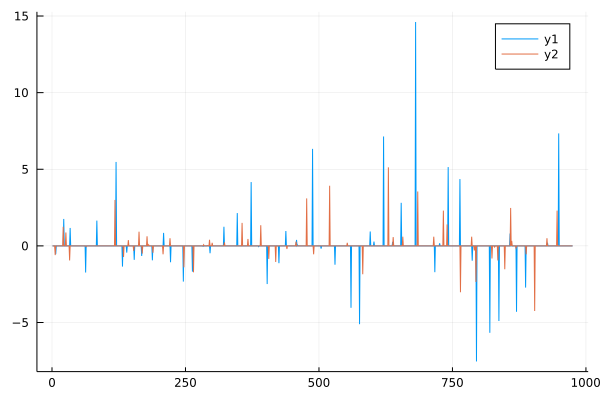

In [38]:
n = length(PL1)
PL1 = PL1[1:n-1]
PL2 = PL2[1:n-1]
annual_return = (sum(PL1) + sum(PL2)) / (maximum(values(prices)[:,1]) + maximum(values(prices)[:,2])) / n * 253
@show annual_return
plot(PL1)
plot!(PL2)



In [27]:
gain1 = count(y->y>0,PL1)
loss1 = count(y->y<0,PL1)
gain2 = count(y->y>0,PL2)
loss2 = count(y->y<0,PL2)
@show gain1,loss1,gain2,loss2

(gain1, loss1, gain2, loss2) = (24, 26, 32, 25)


(24, 26, 32, 25)

In [28]:
function computeScore(PL)
    profit = count(y->y>0,PL)
    loss = count(y->y<0,PL)
    return profit / (profit+loss)
end
@show computeScore(PL1)
@show computeScore(PL2)
(computeScore(PL1)+computeScore(PL2))/2

computeScore(PL1) = 0.48
computeScore(PL2) = 0.5614035087719298


0.5207017543859649

In [29]:
n = length(PL1)

978

In [30]:
function accumulatePlot(PL)
    N = length(PL)
    acc = zeros(N)
    for i in 1:N
        if i == 1
            acc[i] = PL[i]
        else
            acc[i] = acc[i-1] + PL[i]
        end
    end
    return acc
end


accumulatePlot (generic function with 1 method)

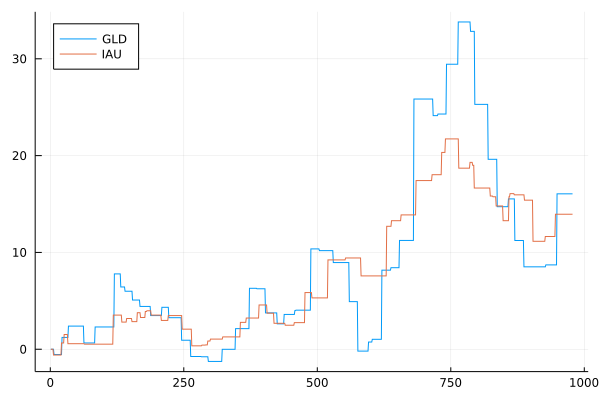

In [31]:
plot(accumulatePlot(PL1),label = tick1,legend=:topleft)
plot!(accumulatePlot(PL2),label = tick2,legend=:topleft)

In [32]:
minimum(accumulatePlot(PL2))

-0.5999984741210938

In [33]:
minimum(accumulatePlot(PL1))

-1.2592010498046875

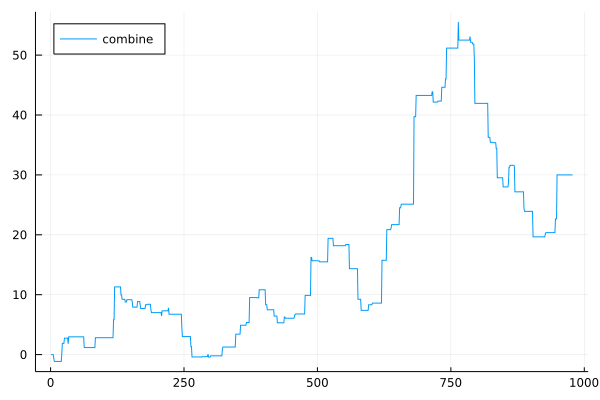

In [34]:
plot(accumulatePlot(PL1+PL2),label = "combine",legend=:topleft)

In [35]:
minimum(accumulatePlot(PL1+PL2))

-1.1399993896484375